In [1]:
# imports
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import numpy as np
import os
import random

In [2]:
# download dlib models
from dlib_models import download_model, download_predictor, load_dlib_models
download_model()
download_predictor()
from dlib_models import models

File already exists:
	c:\users\aleks_000\desktop\bwsi\cogworks_2018\dependencies\dlibmodels\dlib_models\dlib_face_recognition_resnet_model_v1.dat
File already exists:
	c:\users\aleks_000\desktop\bwsi\cogworks_2018\dependencies\dlibmodels\dlib_models\shape_predictor_68_face_landmarks.dat


In [3]:
load_dlib_models()
face_detect = models["face detect"]
shape_predictor = models["shape predict"]

In [4]:
def readfile_emotion(filename):
    with open(filename, mode='r') as file:
        return int(float(file.read().split()[0]))

In [5]:
import matplotlib.image as mpimg

def import_cohn_kanade_full(dataset="database\Cohn-Kanade", extension_images=".png", extension_emotions=".txt", cutoff=0.125):
    images = []
    emotions = []
    
    path_images = os.path.join(dataset, "cohn-kanade-images")
    path_emotions = os.path.join(dataset, "Emotion")
    # for every subject
    subjects = os.listdir(path_images)
    random.shuffle(subjects)
    for di in subjects:
        dire_images = os.path.join(path_images, di)
        dire_emotions = os.path.join(path_emotions, di)
        if os.path.isdir(dire_images) and os.path.isdir(dire_emotions):
            # for every sequence
            for subdi in os.listdir(dire_images):
                subdire_images = os.path.join(dire_images, subdi)
                subdire_emotions = os.path.join(dire_emotions, subdi)
                if os.path.isdir(subdire_images) and os.path.isdir(subdire_emotions):
                    # find the first and only emotion file
                    emotion = None
                    for fi in os.listdir(subdire_emotions):
                        if fi.endswith(extension_emotions) and not fi.startswith("._"):
                            path = os.path.join(subdire_emotions, fi)
                            emotion = readfile_emotion(path)
                            break
                    # for every neutral image
                    valid_images = [fi for fi in os.listdir(subdire_images) if fi.endswith(extension_images) and not fi.startswith("._")]
                    split = int(len(valid_images)*cutoff)
                    for fi_image in valid_images[:split]:
                        path_image = os.path.join(subdire_images, fi_image)
                        image = mpimg.imread(path_image)
                        # add to return array
                        images.append(image)
                        emotions.append(0)
                    if emotion is None:
                        continue
                    # for every emotional image
                    for fi_image in valid_images[split:]:
                        path_image = os.path.join(subdire_images, fi_image)
                        image = mpimg.imread(path_image)
                        # add to return array
                        images.append(image)
                        emotions.append(emotion)
    return [(255*image).astype('uint8') for image in images], emotions

In [ ]:
imgs, y = import_cohn_kanade_full()

In [ ]:
from dlib import get_face_chip

detects = [face_detect(img) for img in imgs]
chips = [get_face_chip(img, shape_predictor(img, detect[0])) for img, detect in zip(imgs, detects) if len(detect) >= 1]

In [84]:
chips = [get_face_chip(img, shape_predictor(img, face_detect(img)[0])) for img in imgs]

In [80]:
from dlib import get_face_chips
from dlib import full_object_detections

detections = face_detect(pic)
full_dets = full_object_detections([shape_predictor(pic, detection) for detection in detections])
chips = get_face_chips(pic, full_dets)

<IPython.core.display.Javascript object>


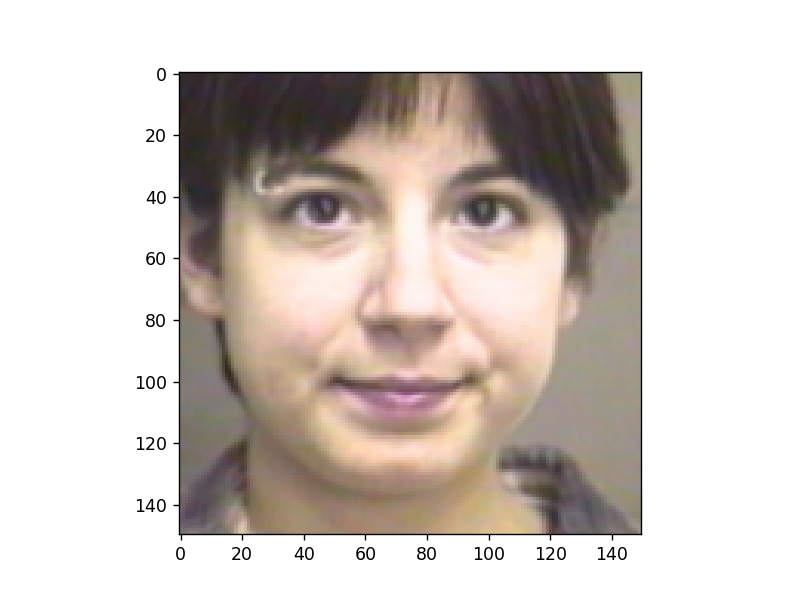

In [87]:
fig, ax = plt.subplots()

for chip in chips:
    ax.clear()
    ax.imshow(chip)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


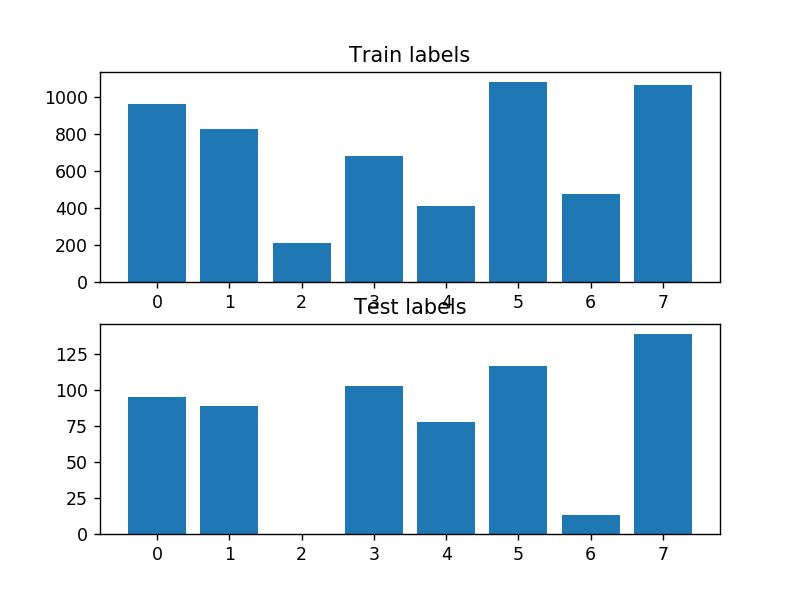

In [1109]:
from collections import Counter

fig, ax = plt.subplots(2)

hist_train = [0]*8
hist_test = [0]*8
for i, c in Counter(ytrain).items():
    hist_train[i] = c
for i, c in Counter(ytest).items():
    hist_test[i] = c
ax[0].bar(range(8), hist_train)
ax[1].bar(range(8), hist_test)
ax[0].set_title("Train labels");
ax[1].set_title("Test labels");

In [1176]:
from mynn.layers.dense import dense
from mynn.initializers.glorot_normal import glorot_normal
from mynn.activations.relu import relu

class Model:
    def __init__(self):
        self.dense1 = dense(2*68, 1000, weight_initializer=glorot_normal)
        self.dense2 = dense(1000, 333, weight_initializer=glorot_normal)
        self.dense3 = dense(333, 100, weight_initializer=glorot_normal)
        self.dense4 = dense(100, 33, weight_initializer=glorot_normal)
        self.dense5 = dense(33, 8, weight_initializer=glorot_normal)
    
    def __call__(self, x):
        return self.dense5(relu(self.dense4(relu(self.dense3(relu(self.dense2(relu(self.dense1(x)))))))))
    
    @property
    def parameters(self):
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters + self.dense4.parameters + self.dense5.parameters

In [1177]:
import mygrad as mg

def accuracy(predictions, truth):
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

In [1178]:
from mynn.optimizers.adam import Adam
import liveplot

model = Model()
optim = Adam(model.parameters)

<IPython.core.display.Javascript object>


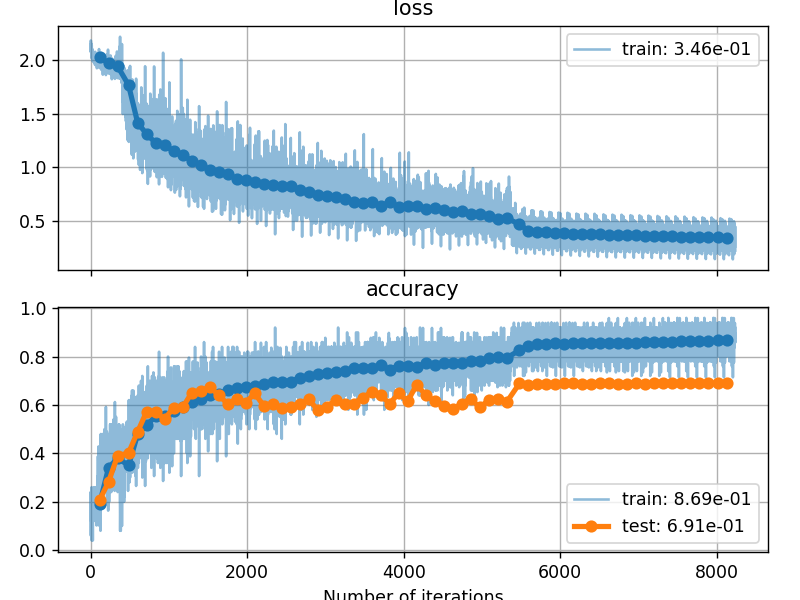

In [1179]:
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)

In [1182]:
from mynn.losses.cross_entropy import softmax_cross_entropy
from math import ceil

optim.learning_rate = 1e-4
optim.weight_decay = 1e-6

batch_size = 50
epochs = 25

Ntrain = ceil(xtrain.shape[0] / batch_size)
Ntest = ceil(xtest.shape[0] / batch_size)
for epoch in range(epochs):
    # train
    for x, y in zip(np.array_split(xtrain, Ntrain), np.array_split(ytrain, Ntrain)):
        y_pred = model(x)

        loss = softmax_cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y)

        loss.backward()
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss":loss.item(),
                                 "accuracy":acc},
                                 batch_size=batch_size)
    # test
    for x, y in zip(np.array_split(xtest, Ntest), np.array_split(ytest, Ntest)):
        y_pred = model(x)
        
        acc = accuracy(y_pred, y)

        y_pred.null_gradients()

        plotter.set_test_batch({"accuracy":acc}, 
                                 batch_size=batch_size)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()

---------------------------------------------
Now, try with a real picture!

<IPython.core.display.Javascript object>


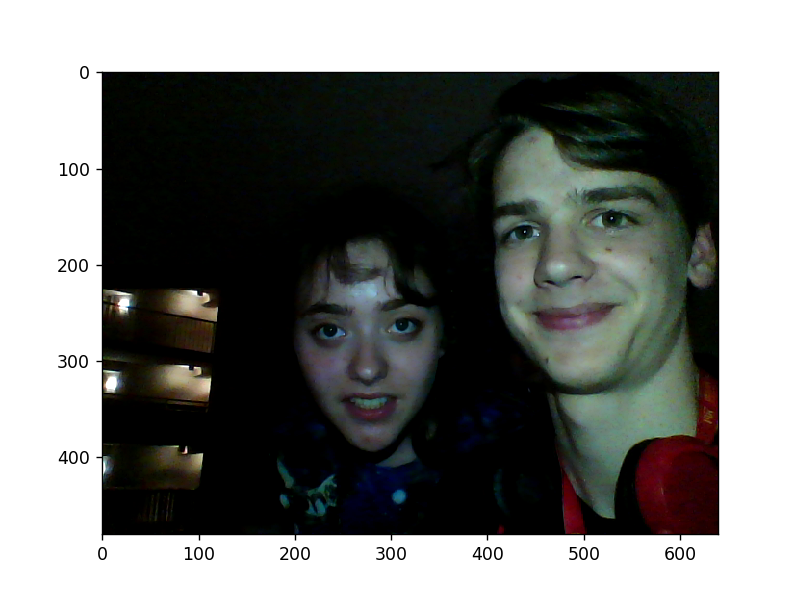

In [19]:
# take picture!
fig,ax = plt.subplots()
pic = take_picture()
ax.imshow(pic)

In [20]:
detections = list(face_detect(pic))
print(detections)

[rectangle(376,90,591,305), rectangle(194,214,373,393)]


<IPython.core.display.Javascript object>


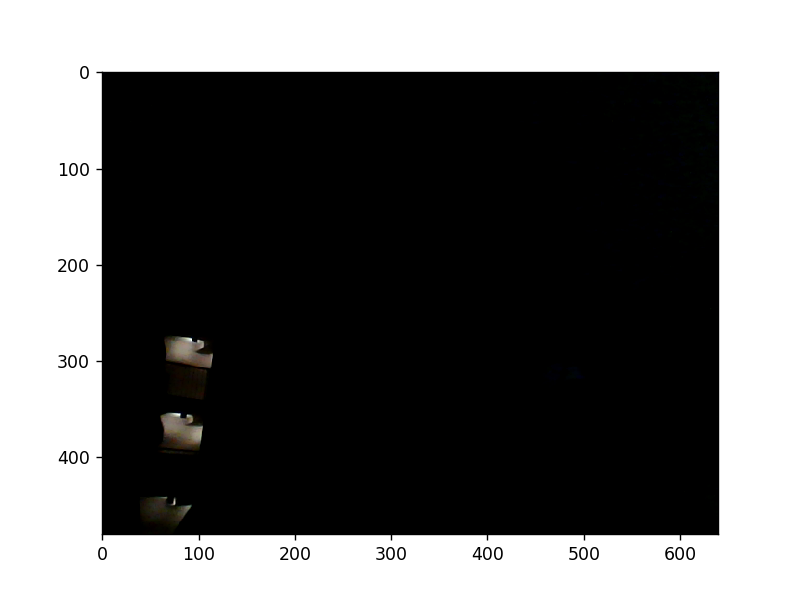

Number of faces detected: 1


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. dlib.shape_predictor()
    2. dlib.shape_predictor(arg0: str)

Invoked with: array([[[ 0,  0,  8],
        [ 0,  0,  8],
        [ 0,  0,  7],
        ...,
        [ 2,  0,  0],
        [ 0,  2, 13],
        [ 0,  3, 14]],

       [[ 0,  0,  6],
        [ 0,  0,  6],
        [ 0,  0,  7],
        ...,
        [ 0,  3,  0],
        [ 0,  3, 22],
        [ 0,  4, 23]],

       [[ 0,  0,  2],
        [ 0,  0,  2],
        [ 0,  0,  3],
        ...,
        [ 0,  4,  0],
        [ 0,  4, 23],
        [ 0,  4, 23]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8), rectangle(136,108,394,366)

In [145]:
from matplotlib.patches import Rectangle
fig,ax = plt.subplots()
ax.imshow(pic)


print("Number of faces detected: {}".format(len(detections)))
for k, d in enumerate(detections):
    # Get the landmarks/parts for the face in box d.
    landmarks = shape_predictor(pic, d)
    # Draw the face landmarks on the screen.
    for i in range(68):
        ax.plot(landmarks.part(i).x,landmarks.part(i).y,'+',color="blue")

In [1326]:
landmarks = shape_predictor(pic, detections[0])
landmarks_arr = np.empty((68, 2))
for i in range(68):
    landmarks_arr[i, 0] = landmarks.part(i).x
    landmarks_arr[i, 1] = landmarks.part(i).y

mean = np.mean(landmarks_arr, axis=0)
std = np.std(landmarks_arr, axis=0)
landmarks_norm = (landmarks_arr - mean) / std

<IPython.core.display.Javascript object>


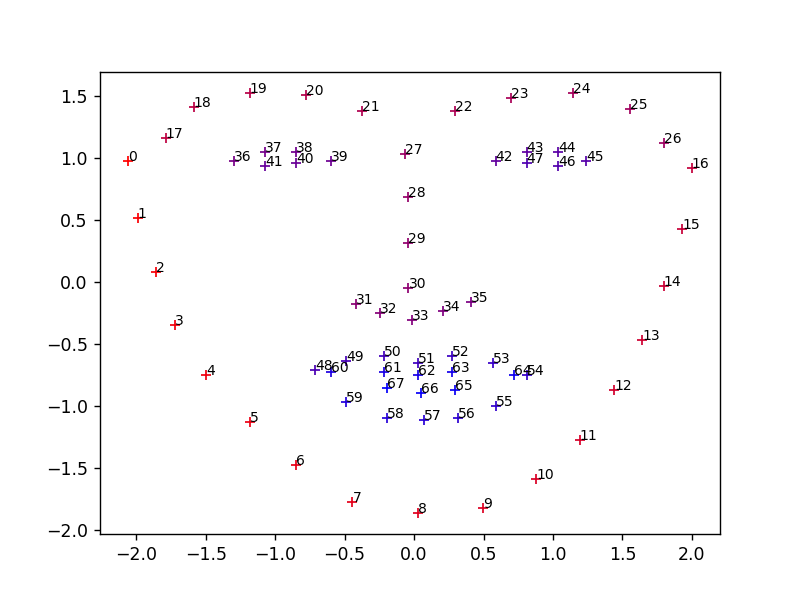

In [1327]:
fig,ax = plt.subplots()

for i in range(68):
    ax.plot(landmarks_norm[i][0],-landmarks_norm[i][1],'+',color=(1-i/68, 0, i/68))
    ax.text(landmarks_norm[i][0],-landmarks_norm[i][1],str(i),color="black",fontsize=8)

In [1328]:
from mynn.activations.softmax import softmax

# try to detect the emotion
landmarks_final = landmarks_norm.reshape(68*2)

labels = ["neutral", "angry", "contempt", "disgusted", "afraid", "happy", "sad", "surprised"]
probs = model(landmarks_final)
probs_soft = softmax(probs)
result = {emotion:probs_soft.data[0][i] for i, emotion in enumerate(labels)}

In [1329]:
top_emotion = max(result.keys(), key=(lambda k: result[k]))
print("You are " + '%.2f' % (result[top_emotion]*100) + "% " + top_emotion)

You are 63.72% neutral
